In [1]:
import csv
import nltk
import string
import pandas as pd
import numpy as np
from google.colab import drive
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/Colab Notebooks/Word Prediction'

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Word Prediction


In [2]:
# Importing the dataset
path = '/content/drive/MyDrive/Colab Notebooks/Word Prediction/ArticlesMarch2018.csv'
df = pd.read_csv(path)
df.head()

,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,2018-03-01 00:17:22,Economy,America has a productivity problem. One explan...,The New York Times,News,https://www.nytimes.com/2018/02/28/business/ec...,1207
1,5a974be7410cf7000162e8af,By HELENE COOPER and ERIC SCHMITT,article,U.S. Advances Military Plans for North Korea,"['United States Defense and Military Forces', ...",1,Washington,11,2018-03-01 00:40:01,Asia Pacific,The American military is looking at everything...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1215
2,5a9752a2410cf7000162e8ba,By THE EDITORIAL BOARD,article,Mr. Trump and the ‘Very Bad Judge’,"['Trump, Donald J', 'Curiel, Gonzalo P', 'Unit...",1,Editorial,26,2018-03-01 01:08:46,Unknown,Can you guess which man is the model public se...,The New York Times,Editorial,https://www.nytimes.com/2018/02/28/opinion/tru...,1043
3,5a975310410cf7000162e8bd,By JAVIER C. HERNÁNDEZ,article,"To Erase Dissent, China Bans Pooh Bear and ‘N’","['China', 'Xi Jinping', 'Term Limits (Politica...",1,Foreign,1,2018-03-01 01:10:35,Asia Pacific,Censors swung into action after Mr. Xi’s bid t...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1315
4,5a975406410cf7000162e8c3,"By JESSE DRUCKER, KATE KELLY and BEN PROTESS",article,Loans Flowed to Kushner Cos. After Visits to t...,"['Kushner, Jared', 'Kushner Cos', 'United Stat...",1,Business,1,2018-03-01 01:14:41,Unknown,"Apollo, the private equity firm, and Citigroup...",The New York Times,News,https://www.nytimes.com/2018/02/28/business/ja...,1566


In [3]:
# Combining all snippets into a series of strings
snippet = '\n'.join(df['snippet'])
print(type(snippet))
print(snippet)

<class 'str'>
America has a productivity problem. One explanation may be the growing use of real resources to make virtual products.
The American military is looking at everything from troop rotations to surveillance to casualty evacuations should it be ordered to take action against North Korea.
Can you guess which man is the model public servant?
Censors swung into action after Mr. Xi’s bid to become leader for life resurrected memories of Mao’s personality cult and the feverish emotions that it created.
Apollo, the private equity firm, and Citigroup made large loans last year to the family real estate business of Jared Kushner, President Trump’s senior adviser.
China has sent a top economic adviser to the United States to restore dialogue and quash a trade war. He faces long odds.
The president mixed facts and falsehoods while discussing gun policy and potential solutions with legislators.
Timothy Polin gives us choices.
Susan Wu, a Silicon Valley entrepreneur, has opened a school i

In [4]:
# Transforming all capitalized words to lower case
corpus = snippet.lower().split('\n')
print(len(corpus))
print(type(corpus))
print(corpus[:2])

1385
<class 'list'>
['america has a productivity problem. one explanation may be the growing use of real resources to make virtual products.', 'the american military is looking at everything from troop rotations to surveillance to casualty evacuations should it be ordered to take action against north korea.']


In [5]:
# Tokenizing words based on frequency of occurence
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_unique_words = len(tokenizer.word_index) + 1 
print(total_unique_words)
print(word_index)

6863
{'the': 1, 'a': 2, 'of': 3, 'to': 4, 'and': 5, 'in': 6, 'for': 7, 'is': 8, 'that': 9, 'on': 10, 'with': 11, 'an': 12, 'it': 13, 'has': 14, 'but': 15, 'new': 16, 'are': 17, 'as': 18, 'at': 19, 'his': 20, 'was': 21, 'president': 22, 'be': 23, 'from': 24, 'trump': 25, 'this': 26, 'about': 27, 'have': 28, 'what': 29, 'you': 30, 'he': 31, 'by': 32, 'who': 33, 'not': 34, 'more': 35, 'their': 36, '—': 37, 'can': 38, 'one': 39, '”': 40, 'its': 41, 'or': 42, 'they': 43, 'after': 44, 'will': 45, 'how': 46, 'do': 47, 'people': 48, 'her': 49, 'could': 50, 'said': 51, 'some': 52, 'into': 53, 'mr': 54, 'i': 55, 'out': 56, 'been': 57, 'house': 58, 'had': 59, 'your': 60, 'we': 61, 'than': 62, 'may': 63, 'like': 64, 'york': 65, 'years': 66, 'she': 67, 'would': 68, 'over': 69, 'up': 70, 'united': 71, 'times': 72, 'last': 73, 'most': 74, 'two': 75, 'all': 76, 'when': 77, 'time': 78, 'city': 79, 'now': 80, 'first': 81, 'year': 82, 'world': 83, 'so': 84, 'it’s': 85, 'our': 86, 'american': 87, 'other':

In [6]:
# Comparing the actual text along with its tokenized version for accuracy
for line in corpus:
   seqs = tokenizer.texts_to_sequences([line])[0]
print(seqs)

[287, 607, 473, 2139, 289, 10, 52, 443, 193, 563, 89, 6862]


In [7]:
# Generating many-to-one N-Gram Sequences
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)): 
    n_gram_seqs = token_list[:i+1]
    input_sequences.append(n_gram_seqs)
print(len(input_sequences))
print(input_sequences)

26937
[[193, 14], [193, 14, 2], [193, 14, 2, 2796], [193, 14, 2, 2796, 699], [193, 14, 2, 2796, 699, 39], [193, 14, 2, 2796, 699, 39, 1177], [193, 14, 2, 2796, 699, 39, 1177, 63], [193, 14, 2, 2796, 699, 39, 1177, 63, 23], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4, 105], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4, 105, 1646], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4, 105, 1646, 700], [1, 87], [1, 87, 490], [1, 87, 490, 8], [1, 87, 490, 8, 701], [1, 87, 490, 8, 701, 19], [1, 87, 490, 8, 701

In [8]:
# Padding N-Grams to be of the same length
max_seq_length = max([len(x) for x in input_sequences])
input_seqs = np.array(pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre'))
print(max_seq_length)
print(input_seqs[:5])

41
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0  193   14]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  193   14    2]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0  193   14    2 2796]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  193   14    2 2796  699]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     

In [9]:
# Extracting features and labels
x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
y_values = tf.keras.utils.to_categorical(labels, num_classes=total_unique_words)
print(x_values[:3])
print(labels[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 193]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 193  14]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 193  14   2]]
[  14    2 2796]


In [10]:
# Frequency count of similar words
print(tokenizer.word_index['good'])
print(tokenizer.word_index['great'])

299
673


In [11]:
# Importing the GloVe embedding text file with a 100-dimensional array
path = '/content/drive/MyDrive/Colab Notebooks/Word Prediction/glove.6B.100d.txt'
embeddings_index = {}
with open(path) as f:
  for line in f:
    values = line.split()
    word = values[0]
    coeffs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coeffs

# Visualizing the 100-dimensions of each word
dict(list(embeddings_index.items())[0:2])

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [12]:
#  Creating a matrix which contains the GloVe word embeddings (ie. 100-dimensional arrays) only for the words in our vocabulary
embeddings_matrix = np.zeros((total_unique_words, 100))
for word, i in word_index.items():
   embedding_vector = embeddings_index.get(word)
   if embedding_vector is not None:
     embeddings_matrix[i] = embedding_vector;

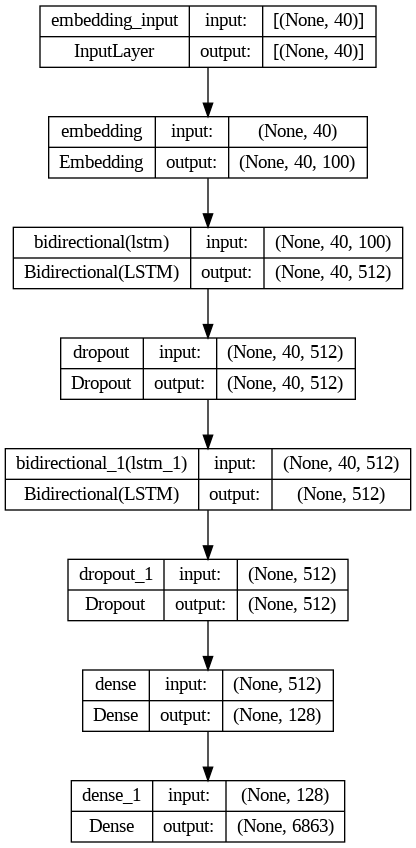

In [13]:
# Building and visualizing the model
K.clear_session()
model = tf.keras.Sequential([
tf.keras.layers.Embedding(input_dim = total_unique_words, output_dim=100, weights=[embeddings_matrix], input_length=max_seq_length-1, trainable=False),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
tf.keras.layers.Dropout(0.2), 
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(total_unique_words , activation='softmax')])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
# Training the model
history = model.fit(x_values, y_values, epochs=120, validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/120
85/85 [==============================] - 20s 87ms/step - loss: 7.6502 - accuracy: 0.0476 - val_loss: 7.5667 - val_accuracy: 0.0496
Epoch 2/120
85/85 [==============================] - 6s 67ms/step - loss: 7.1343 - accuracy: 0.0511 - val_loss: 7.7333 - val_accuracy: 0.0496
Epoch 3/120
85/85 [==============================] - 6s 68ms/step - loss: 7.0771 - accuracy: 0.0512 - val_loss: 7.7388 - val_accuracy: 0.0553
Epoch 4/120
85/85 [==============================] - 6s 67ms/step - loss: 6.9523 - accuracy: 0.0647 - val_loss: 7.6374 - val_accuracy: 0.0700
Epoch 5/120
85/85 [==============================] - 6s 69ms/step - loss: 6.7769 - accuracy: 0.0708 - val_loss: 7.6907 - val_accuracy: 0.0707
Epoch 6/120
85/85 [==============================] - 6s 67ms/step - loss: 6.6413 - accuracy: 0.0742 - val_loss: 7.7497 - val_accuracy: 0.0767
Epoch 7/120
85/85 [==============================] - 6s 69ms/step - loss: 6.5462 - accuracy: 0.0754 - val_loss: 7.7614 - val_accuracy: 0.0809
Epoch

In [48]:
# Prediction using the model
def prediction(seed_text, next_words): 
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_length-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=1), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += ' '+output_word
        print(seed_text)

seed_phrase = "I understand that they could meet"
next_words = len("with us, patronize us and do nothing in the end".split())
prediction(seed_phrase, next_words)

1/1 [==============================] - 0s 23ms/step
I understand that they could meet alienating
1/1 [==============================] - 0s 20ms/step
I understand that they could meet alienating on
1/1 [==============================] - 0s 22ms/step
I understand that they could meet alienating on broadway
1/1 [==============================] - 0s 21ms/step
I understand that they could meet alienating on broadway penguins
1/1 [==============================] - 0s 23ms/step
I understand that they could meet alienating on broadway penguins and
1/1 [==============================] - 0s 33ms/step
I understand that they could meet alienating on broadway penguins and the
1/1 [==============================] - 0s 35ms/step
I understand that they could meet alienating on broadway penguins and the state’s
1/1 [==============================] - 0s 44ms/step
I understand that they could meet alienating on broadway penguins and the state’s movement
1/1 [==============================] - 0s 37ms/step